In [1]:
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.stats import chi2
from matplotlib import pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
def chiSq(modelparam, model, x, y, yerr):
    '''sum up all the square reduced residuals for use in chisquared'''
    return np.sum(((y-model(x, *modelparam))/yerr)**2) 
rho = 1058.5 # kg/m^3
eta = 0.0018694 # Ns/m^-2
r = 0.007/2 # m

In [2]:
def dampedSine(x, a, b, c, d, e):
    return a * np.exp(b*x) * np.sin(c*x+d) + e

In [3]:
def analyse(filename, plot=True, prnt=True, ax=None):
    q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
    t = q[0]
    y = q[2]
    # incase we need to skip the first few datapoints
    skip = 0
    y = y[skip:]
    t = t[skip:] - t[skip]
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    ### see comment in multi analyse about errors
    y_err = np.full(shape=y.shape, fill_value=0.1)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            ax = plt.figure()
        plt.scatter(t, y, label=f"{filename}")
        plt.plot(t, dampedSine(t, *P[0]), color="r", label="Decaying Sine Curve")
        plt.legend()
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

In [4]:
hs = np.array([3,6,9]) # immersion depth of straw, cm
H = 20 # length of straw, cm
g = 9.8 # gravity, ms^-2
D = 0.007 # diameter of straw, m

P_atm = 1030

t_norms = (hs*1e-2/g)**-0.5 #normalisation constant, 1e-2 cm to m

# Calculated using "http://www.met.reading.ac.uk/~sws04cdw/viscosity_calc.html"
# 0%, 10%, 20%, ..., 70% by volume
# all values at 23degC
rho = 1058.5 # kg/m^3
eta = 0.0018694 # Ns/m^-2

def DZ_dt_Lor(Z, t, args):
    Omeg = args[0]
    if Z[1]>0:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1] - (Z[1])**2/Z[0]]
    else:
        return [Z[1], 1/Z[0] - 1 -Omeg*Z[1]]

def LorloadData(filename):
    data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
    time_data = data[:,0]
    z_data = data[:,2]*100 # bc in m

    timeshift = time_data[0] # shifted so that t=0 is the time in video that the cap is released.
    time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
    z_data_clean = z_data[np.isfinite(z_data)]
    z_err = np.full(shape=z_data_clean.shape, fill_value=0.1)
    #z_err = np.sqrt(np.array([0] + [abs(z_data_clean[i] - (z_data_clean[i-1] + z_data_clean[i+1])/2) for i in range(1, len(z_data_clean)-1)] + [0]))+0.01

    #z_0 = 1.954e-2 # height of liquid in straw, cm # calculated as d
    height = (int(filename[3])//3)-1
    h = hs[height] # Ns/m^-2
    t_norm = t_norms[height] # kg/m^3
    omeg = 16 * eta * (h * 10**-2)**0.5 / (rho * (D/2)**2 * g**0.5)
    d = (1 - P_atm/(rho*(10**-3)*h + P_atm))*H # initial height of liquid in straw
    #d = z_data_clean[0]+h

    def func(t, factor):
        Omeg = omeg*factor
        t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.001)
        Z_soln = sp.integrate.odeint(DZ_dt_Lor, [d, 0.00], t_solnLor, args=((Omeg,),))
        z_soln = Z_soln[:, 0]*h
        t_solnLor /= t_norm # unnormalise to compare to real 
        # find corresponding t values and the z_soln for them
        # searchsorted should be safe as the time data will all be in order
        zout = z_soln[np.searchsorted(t_solnLor, t)-1]
        return zout-h

    return time_data_clean, z_data_clean, z_err, omeg, func

# currently taking the h to be constant at 9cm (which is what we set it as)
# allowing it to vary in the model is interesting but ultimately wrong
def Loranalyse(filename):
    timedata, zdata, zerr, omeg, func = LorloadData(filename)
    P = curve_fit(func, timedata, zdata, p0=(1),  sigma=zerr, absolute_sigma=True)
    vals = P[0]
    err = np.sqrt(np.diag(P[1]))
    height = (int(filename[3])//3)-1
    h = [hs[height],0.1] # Ns/m^-2
    factor = [vals[0], err[0]]
    Omeg = [vals[0]*omeg, err[0]*omeg]

    return factor, h, func, timedata, zdata, zerr

def LoranalyseAll(Filenames):
    favg = 0
    tmax = 0
    timedatas = []
    ys = []
    yerrs = []
    for file in Filenames:
        try:
            factor, h, func, timedata, y, yerr = Loranalyse(file)
            timedatas.extend(timedata)
            ys.extend(y)
            yerrs.extend(yerr)
            favg += factor[0]
        except FileNotFoundError:
            print(f"Datafile {file} not found")
    favg /= 3
    tmax = max(timedatas)
    timedata = np.arange(0, tmax, 0.01)
    chisqmin = chiSq((favg,), func, timedatas, ys, yerrs)
    DoF = len(timedatas) - 1
    redchisqmin = chisqmin / DoF
    rs = round(redchisqmin, 1-int(np.floor(np.log10(redchisqmin))))
    print(rs)
    plt.plot(timedata[1:], func(timedata[1:], factor[0])+h[0], "y--", label="Lorenceau Model")

In [5]:
#vals = []
#for h in range(3, 12, 3):
#    v = []
#    ax = None #plt.figure()
#    for file in [f"30%{h}cmV1",f"30%{h}cmV2",f"30%{h}cmV3"]:
#        ps = analyse(file, False, False, ax)
#        v.append(ps)
#    vals.append(v)
#vals=np.array(vals)
#hs = np.array([[x,x,x] for x in range(3, 12, 3)]).flatten()

# take all data sets, take all 3 videos,
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
#SingAs = abs(vals[:, :, 0, 0]).flatten()
#SingAerr = vals[:, :, 1, 0].flatten()
#SingBs = vals[:, :, 0, 1].flatten()
#SingBerr = vals[:, :, 1, 1].flatten()
#SingCs = abs(vals[:, :, 0, 2]).flatten()
#SingCerr = vals[:, :, 1, 2].flatten()
#SingDs = vals[:, :, 0, 3].flatten()
#SingDerr = vals[:, :, 1, 3].flatten()
#SingEs = vals[:, :, 0, 4].flatten()
#SingEerr = vals[:, :, 1, 4].flatten()

In [6]:
def quad(x, a, b, c):
    return a*x**2+b*x+c

def linear(x, a, b):
    return a*x+b

def plotCoeff(x, y, yerr, title_="", ylabel_="", xlabel_="Depth of straw / cm", ax=None, residuals=True, lin=True):
    if lin is True:
        fitter=linear
        pguess=(1,1)
    else:
        fitter=quad
        pguess=(1,1,1)
    if ax is None:
        fig = plt.figure()
    pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=pguess, sigma=None, absolute_sigma=True)
    xs = np.linspace(3, x[-1])
    ys = fitter(xs, *pfit)
    
    # main data and model plot
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    #ax1.set_title("$A * exp(B*t) * sin(C*t+D) + E$, " + title_)
    ax1.set_xlabel(xlabel_)
    ax1.set_ylabel(ylabel_)

    if residuals:
        #residuals
        xs = x
        yres = y - fitter(xs, *pfit)
        ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
        ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
        ax2.set_xlabel("Depth of straw / cm")
        ax2.set_ylabel("Residuals")

        #histogram
        ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
        ax3.hist(x=yres, bins=8, orientation="horizontal")

        chisqmin = chiSq(pfit, fitter, x, y, yerr)
        DoF = x.size - len(pguess)
        redchisqmin = chisqmin / DoF

        p_val = chi2.sf(chisqmin, DoF)

        return pfit, np.sqrt(np.diag(pcov)), redchisqmin, p_val
    else:
        return pfit, np.sqrt(np.diag(pcov))

In [7]:
#plot As 
# function of Initial Depth, uninteresting for current experiment
#plotCoeff(conc, SingAs, SingAerr, "Maximum Amplitude $A$", "$A$, ($cm$)")

#plot Bs
# Decay Rate, interesting negative correlation
#plotCoeff(hs, SingBs, SingBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False)

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
#plotCoeff(hs, SingCs, SingCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False)

#plot Ds
# Phase shift, uninteresting in all.
#plotCoeff(conc, SingDs, SingDerr, "Phase Shift $D$", "$D$, (radians)")

#Plot Es
# A shift of the axes, uninteresting
#plotCoeff(conc, SingEs, SingEerr, "Zero-point Shift $E$", "$E$, ($cm$)")

In [14]:
def multianalyse(filenames, plot=True, prnt=True, ax=None):
    ts = []
    ys = []
    for filename in filenames:
        q = np.genfromtxt(filename,delimiter='\t',skip_header=2).T
        t = q[0]
        y = q[2]
        # incase we need to skip data points,
        # less useful for large datasets 
        # or when using for many different files
        skip = 0
        height = (int(filename[3])//3)-1
        h = hs[height] # Ns/m^-2
        y = y[skip:]*100 + h # m to cm
        t = t[skip:] - t[skip]
        ys.extend(y)
        ts.extend(t)
    y = np.array(ys)
    t = np.array(ts)
    yp = y[np.isfinite(y)]
    t = t[np.isfinite(y)]
    y = yp
    # sort t, sort y in same way
    way = t.argsort()
    t = t[way]
    y = y[way]
    # errors are currently quite ill defined
    ### could use a damped cosine curve for the error?
    y_err = np.full(shape=y.shape, fill_value=0.1)
    P = curve_fit(dampedSine, t, y, sigma=y_err, absolute_sigma=True)
    if plot:
        if ax is None:
            plt.figure()
        plt.plot(t, y, label=f"{filename[3:-2]}")
        q = dampedSine(t, *P[0])
        chisqmin = chiSq(P[0], dampedSine, t, y, y_err)
        DoF = t.size - len(P[0])
        redchisqmin = chisqmin / DoF
        rs = round(redchisqmin, 1-int(np.floor(np.log10(redchisqmin))))
        print(rs)
        plt.plot(t, dampedSine(t, *P[0]), "r--", label="Decaying Sine Curve")
        LoranalyseAll(filenames)
        #plt.xlabel("time (s)")
        #plt.ylabel("Water level above bottom of straw (cm)")
        #plt.xlim(left=-0.1)
        plt.ylim(bottom=-0.1)
        plt.legend(loc="lower right")
    if prnt:
        for e, a, b in zip("ABCDE", P[0], np.sqrt(np.diag(P[1]))):
            print(e, ":", a, "+/-", b)
        print()

    return np.array([P[0], np.sqrt(np.diag(P[1]))])

2.3
11.0
A : 2.4999857754097143 +/- 0.019857641820293436
B : -3.385771214907931 +/- 0.036800711692377856
C : 16.555989320352438 +/- 0.04040972024590394
D : -1.4498543035152547 +/- 0.008810954133882136
E : 3.2562096181500735 +/- 0.0025252461645121063

5.2
25.0
A : 5.479470147047607 +/- 0.016579808674450455
B : -2.131397477460138 +/- 0.008646271266831117
C : 11.316641088283438 +/- 0.00890954706151429
D : -1.3270339329285095 +/- 0.002999109468167303
E : 6.206020316481603 +/- 0.0020677430611051525

33.0
150.0
A : 10.003193721040061 +/- 0.015216931359781891
B : -1.918789795232459 +/- 0.00397264485964341
C : 9.20515125314819 +/- 0.0043687695348883036
D : -1.4424113916763461 +/- 0.0016850396840667496
E : 9.326651378488082 +/- 0.0023118151470083647



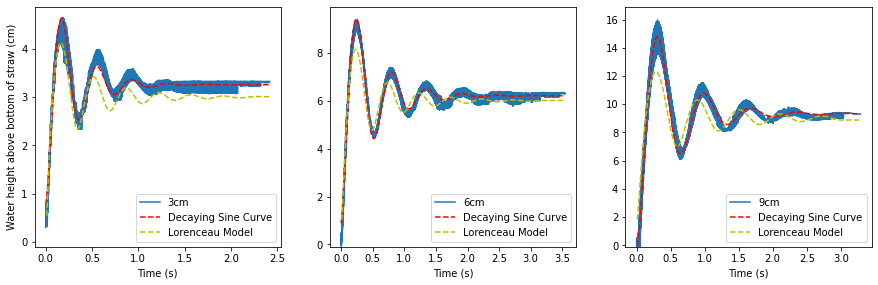

In [15]:
ax = plt.figure(figsize=(15,15))
# 1 2 3
# 4 5 6
# 7 8 9
pt = 1
vals = []
for h in range(3, 12, 3):
    v = []
    plt.subplot(3,3,pt)
    if pt == 1:
        plt.ylabel("Water height above bottom of straw (cm)")
    plt.xlabel("Time (s)")
    pt += 1
    ps = multianalyse([f"30%{h}cmV1",f"30%{h}cmV2",f"30%{h}cmV3"], True, True, ax=ax)
    v.append(ps)
    vals.append(v)

vals=np.array(vals)
hs = np.array([[x] for x in range(3, 12, 3)]).flatten()

# take all data sets, take the 0th element (3 videos combined into 1),
# then the 0th for data and 1st for err,
# then 0,1,2,3,4 for appropriate variable
# then flatten into one list
# take absolute values for A and C as these can be negative for no real reason
# ie when A is negative C is negative to compensate => artifact of curvefitting
MulAs = abs(vals[:, 0, 0, 0]).flatten()
MulAerr = vals[:, 0, 1, 0].flatten()
MulBs = vals[:, 0, 0, 1].flatten()
MulBerr = vals[:, 0, 1, 1].flatten()
MulCs = abs(vals[:, 0, 0, 2]).flatten()
MulCerr = vals[:, 0, 1, 2].flatten()
MulDs = vals[:, 0, 0, 3].flatten()
MulDerr = vals[:, 0, 1, 3].flatten()
MulEs = vals[:, 0, 0, 4].flatten()
MulEerr = vals[:, 0, 1, 4].flatten()

(array([ 1.25053466, -1.50899139]), array([0.23570226, 1.52752523]))
(array([-0.05787589,  0.93900761, -5.68191101]), array([0.13608275, 1.64991572, 4.35889872]))
(array([ 0.17376991, -3.31037861, 24.92319595]), array([0.13608277, 1.64991585, 4.35889896]))


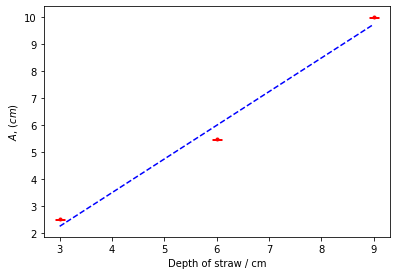

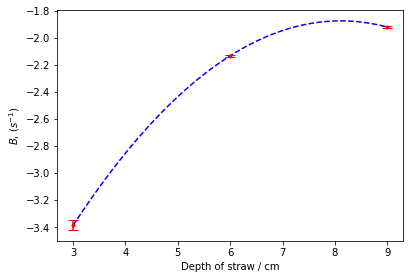

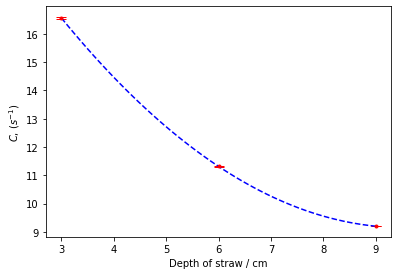

In [10]:
print(plotCoeff(hs, MulAs, MulAerr, "Decay Rate $A$", "$A$, ($cm$)", residuals=False,lin=True))

#Only interesting plots are B and C, others are variables to translate the model around to fit as seen in singular analysis
#es = np.array(etas)
#rs = np.array(rhos)
#plot Bs
# Decay Rate, interesting negative correlation
print(plotCoeff(hs, MulBs, MulBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)", residuals=False,lin=False))
#print(plotCoeff(es/rs, MulBs, MulBerr, "Decay Rate $B$", "$B$, ($s^{-1}$)",\
     #xlabel_="$\eta / \\rho$ ($m^2 s^{-1}$)", residuals=False, fitter=linear, pguess=(1,1)))

#print(plotCoeff(conc[:-1], MulBs[:-1], MulBerr[:-1], "Decay Rate $B$, Removed 70%", "$B$, ($s^{-1}$)", residuals=False))

#plot Cs
# Frequency of Oscillation, uninteresting seemingly constant
print(plotCoeff(hs, MulCs, MulCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)", residuals=False,lin=False))
#print(plotCoeff(es/rs, MulCs, MulCerr, "Frequency of Oscillation $C$", "$C$, ($s^{-1}$)",\
     #xlabel_="$\eta / \\rho$ ($m^2 s^{-1}$)", residuals=False, fitter=linear, pguess=(1,1)))
#print(plotCoeff(conc[:-1], MulCs[:-1], MulCerr[:-1], "Frequency of Oscillation $C$, Removed 70%", "$C$, ($s^{-1}$)", residuals=False))

In [11]:
def loadData(filename):
    data = np.genfromtxt(filename,delimiter='\t',skip_header=2 )
    time_data = data[:,0]
    z_data = data[:,2]*100 # bc in m

    timeshift = time_data[0] # shifted so that t=0 is the time in video that the cap is released.
    time_data_clean = time_data[np.isfinite(z_data)]-timeshift # cleaned data includes the timeshift, and removes any instances of infinite.
    z_data_clean = z_data[np.isfinite(z_data)]
    z_err = np.full(shape=z_data_clean.shape, fill_value=0.5)
    #z_err = np.sqrt(np.array([0] + [abs(z_data_clean[i] - (z_data_clean[i-1] + z_data_clean[i+1])/2) for i in range(1, len(z_data_clean)-1)] + [0]))+0.01

    #z_0 = 1.954e-2 # height of liquid in straw, cm # calculated as d
    height = (int(filename[3])//3)-1
    h = hs[height] # Ns/m^-2
    t_norm = t_norms[height] # kg/m^3
    omeg = 16 * eta * (h * 10**-2)**0.5 / (rho * (D/2)**2 * g**0.5)
    d = (1 - P_atm/(rho*(10**-3)*h + P_atm))*H # initial height of liquid in straw
    #d = z_data_clean[0]+h

    def func(t, factor):
        Omeg = omeg*factor
        t_solnLor = np.arange(0, round(max(time_data_clean)*t_norm, 3), 0.001)
        Z_soln = sp.integrate.odeint(DZ_dt_Lor, [d, 0.00], t_solnLor, args=((Omeg,),))
        z_soln = Z_soln[:, 0]*h
        t_solnLor /= t_norm # unnormalise to compare to real 
        # find corresponding t values and the z_soln for them
        # searchsorted should be safe as the time data will all be in order
        zout = z_soln[np.searchsorted(t_solnLor, t)-1]
        return zout-h

    return time_data_clean, z_data_clean, z_err, omeg, func

def analyse(filename, plot=False, ax=None):
    timedata, zdata, zerr, omeg, func = loadData(filename)
    P = curve_fit(func, timedata, zdata, p0=(1),  sigma=zerr, absolute_sigma=True)
    vals = P[0]
    err = np.sqrt(np.diag(P[1]))
    height = (int(filename[3])//3)-1
    h = [hs[height],0.1] # Ns/m^-2
    if plot:
        if ax is None:
            ax = plt.figure()
        plt.errorbar(timedata, zdata+h[0], zerr, fmt="b.", capsize=2, label=f"{filename}")
        plt.plot(timedata[1:], func(timedata[1:], *P[0])+h[0], "g--", label="Lorenceau Numerical Integration")
        plt.legend()
    factor = [vals[0], err[0]]
    Omeg = [vals[0]*omeg, err[0]*omeg]

    return factor, Omeg, h

def analyseAll(plots=False):
    filenames = []
    data = []
    for h in range(3, 12, 3):
        for file in [f"30%{h}cmV1",f"30%{h}cmV2",f"30%{h}cmV3"]:
            try:
                d = analyse(file, plot=plots)
                filenames.append(file)
                data.append(d)
            except FileNotFoundError:
                print(f"Datafile {file} not found")
    return np.array(filenames), np.array(data)

Filenames, Data = analyseAll(False)

In [12]:
# potential fitting regimes
linear = lambda x, a, b: a*x+b # pguess = (1,1)
quadratic = lambda x, a, b, c: a*x**2+b*x+c # pguess = (1,1,1)
expon = lambda x, a, b, c: a * np.exp(b*x) + c # pguess = (1, 1, 1)
expxonx = lambda x, a, b, c: a * np.exp(b*x) / (b*x) + c # pguess = (1,1,1)

def plotCoeff(x, y, yerr, title_="", ylabel_="", xlabel_="Depth of straw / cm", fitter=quadratic, pguess=(1,1,1), residuals=True, fitlow=None, fithigh=None,**kwds):
    fig = plt.figure()
    if fitlow is None or fithigh is None:
        pfit, pcov = curve_fit(f=fitter, xdata=x, ydata=y, p0=pguess, 
                            sigma=None, absolute_sigma=True, **kwds)
    else:
        pfit, pcov = curve_fit(f=fitter, xdata=x[fitlow:fithigh], ydata=y[fitlow:fithigh], p0=pguess, 
                            sigma=None, absolute_sigma=True, **kwds)
        
    xs = np.linspace(3**0.5, x[-1])
    ys = fitter(xs, *pfit)

    #main data and model
    ax1 = fig.add_axes((0, 0.2, 0.8, 0.8))
    ax1.errorbar(x=x, y=y, yerr=yerr, fmt="r.", capsize=5)
    ax1.plot(xs, ys, "b--")
    #ax1.set_title("Lorenceau fit, " + title_)
    ax1.set_xlabel(xlabel_)
    ax1.set_ylabel(ylabel_)

    #residuals
    if residuals:
        xs = x
        yres = y - fitter(xs, *pfit)
        ax2 = fig.add_axes((0, 0, 0.8, 0.2), sharex=ax1)
        ax2.errorbar(xs, yres, yerr, fmt="b.", capsize=5, )
        ax2.set_xlabel(xlabel_)
        ax2.set_ylabel("Residuals")

        #histogram
        ax3 = fig.add_axes((0.8, 0, 0.2, 0.2), sharey=ax2)
        ax3.hist(x=yres, bins=8, orientation="horizontal")
        
        #chisq of fitting values
        chisqmin = chiSq(pfit, fitter, x, y, yerr)
        DoF = x.size - len(pguess)
        redchisqmin = chisqmin / DoF

        p_val = chi2.sf(chisqmin, DoF)

        return pfit, np.sqrt(np.diag(pcov)), redchisqmin, p_val
    else:
        return pfit, np.sqrt(np.diag(pcov))

def plotData(filenames, data):
    conc = np.array([int(x[0])*10 for x in filenames])
    print("Factor", plotCoeff(x=conc, y=data[:, 0, 0], yerr=data[:, 0, 1], title_="Factor", \
        ylabel_="Factor (unitless)", fitter=linear, pguess=(1,1), residuals=False))

    print("Omega Linear", plotCoeff(x=conc, y=data[:, 1, 0], yerr=data[:, 1, 1], title_="Omega",\
        ylabel_="Omega (unitless)", fitter=linear, pguess=(1,1), residuals=False))

    print("Omega Quadratic", plotCoeff(x=conc, y=data[:, 1, 0], yerr=data[:, 1, 1], title_="Omega",\
        ylabel_="Omega (unitless)", fitter=quadratic, pguess=(1,1,1), residuals=False))

    # print("Omega Exp", plotCoeff(x=conc, y=data[:, 1, 0], yerr=data[:, 1, 1], title_="Omega", \
    #     ylabel_="Omega (unitless)", fitter=expon, pguess=(0.001, 5, 1), residuals=False))

    # print("Omega Exp(x)/x", plotCoeff(x=conc, y=data[:, 1, 0], yerr=data[:, 1, 1], title_="Omega", \
    #     ylabel_="Omega (unitless)", fitter=expxonx, pguess=(0.001, 5, 1), residuals=False))
    

def plotDataMulti(filenames, data):
    #conc = np.array([int(x[0])*10 for x in filenames[::3]])
    #es = np.array(etas)
    #rs = np.array(rhos)

    ys = np.array([np.average(data[x:x+3, 0, 0]) for x in range(0, len(data), 3)])
    yerr = np.array([np.sqrt(np.average(data[x:x+3, 0, 1]**2)) for x in range(0, len(data), 3)])
    # print("Factor Linear", plotCoeff(conc, ys, yerr, \
    #     title_="Factor", ylabel_="Factor (unitless)", fitter=linear, pguess=(1,1), residuals=False))

    ys = np.array([np.average(data[x:x+3, 1, 0]) for x in range(0, len(data), 3)])
    yerr = np.array([np.sqrt(np.average(data[x:x+3, 1, 1]**2)) for x in range(0, len(data), 3)])
    # print("Omega Linear", plotCoeff(x=conc, y=ys, yerr=yerr, \
    #     title_="Omega", ylabel_="Omega (unitless)", fitter=linear, pguess=(1,1), residuals=False,\
    #         fitlow=0, fithigh=-1))
    # print("Omega Linear", plotCoeff(x=conc[:-1], y=ys[:-1], yerr=yerr[:-1], \
    #     title_="Omega", ylabel_="Omega (unitless)", fitter=linear, pguess=(1,1), residuals=False))
    # print("Omega Quadratic", plotCoeff(conc, ys, yerr, \
    #     title_="Omega", ylabel_="Omega (unitless)", fitter=quadratic, pguess=(1,1,1), residuals=False))
    # print("Omega Quadratic", plotCoeff(conc[:-1], ys[:-1], yerr[:-1], \
    #     title_="Omega", ylabel_="Omega (unitless)", fitter=quadratic, pguess=(1,1,1), residuals=False))
    print("Omega vs H",plotCoeff(hs**(1/2), ys, yerr, "Omega", "Omega (unitless)", \
        xlabel_="$h^{1/2}$ ($cm^{1/2}$)",fitter=linear, pguess=(0,0.3), residuals=False))
    #print("Omega vs Eta/Rho",plotCoeff(es/rs**(3/2), ys, yerr, "Omega", "Omega (unitless)", \
        #xlabel_="$\eta / \\rho^{3/2}$ ($m^2 s^{-1}$)",fitter=linear, pguess=(0,0.3), residuals=False))    
    # print("Omega vs Eta/Rho",plotCoeff((es/rs)[:-1], ys[:-1], yerr[:-1], "Omega", "Omega (unitless)", \
    #     xlabel_="$\eta / \\rho$ ($m^2 s^{-1}$)",fitter=linear, pguess=(0,0.3), residuals=False))

Omega vs H (array([-0.00607869,  0.22947749]), array([1.112147  , 2.72419262]))


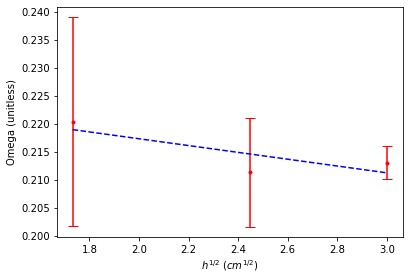

In [13]:
# both plots use linear fits and dont fit visually.
# i think this is mostly due to errorbar size on most of the values
#plotData(Filenames, Data)
plotDataMulti(Filenames, Data)